# Phase 3: Dual-Branch Meta-Labeling Model

## Overview
This notebook implements a dual-branch neural network architecture for meta-labeling:
- **Branch 1 (Classification)**: Predicts entry signal confidence (should we take this trade?)
- **Branch 2 (Regression)**: Predicts outcome heatmap (signed_heatmap_entry: [-1, +1])

## Architecture
Inspired by swim_code dual-branch CNN-LSTM:
- Shared CNN layers for feature extraction
- Branch 1: CNN → Flatten → Dense → Sigmoid (binary classification)
- Branch 2: CNN → LSTM → Dense → Tanh (regression to [-1, +1])

## Input/Output
- Input: Sequences (60, n_features) from Phase 2
- Output 1: Entry confidence [0, 1]
- Output 2: Outcome prediction [-1, +1]

---

## 1. Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import pickle 

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm

# Sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU available: []


## 2. Configuration

In [8]:
# Paths
DATA_DIR = Path('../DATA')
MODEL_DIR = Path('../MODELS')
MODEL_DIR.mkdir(exist_ok=True)

# Random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Model hyperparameters
CONFIG = {
    # Architecture
    'shared_conv_filters': [32, 64, 128],
    'shared_kernel_sizes': [3, 3, 3],
    'shared_strides': [1, 1, 1],
    'shared_pool_sizes': [2, 2, 2],
    
    # Branch 1 (Classification)
    'class_dense_units': [64, 32],
    'class_dropout': 0.3,
    'class_l2': 0.001,
    
    # Branch 2 (Regression)
    'reg_lstm_units': 64,
    'reg_lstm_dropout': 0.2,
    'reg_lstm_recurrent_dropout': 0.2,
    'reg_dense_units': [32],
    'reg_dropout': 0.2,
    'reg_l2': 0.001,
    
    # Training
    'batch_size': 64,
    'epochs': 100,
    'learning_rate': 0.001,
    'patience': 15,
    
    # Loss weights (balance between classification and regression)
    'classification_weight': 0.4,
    'regression_weight': 0.6,
}

print("Configuration loaded:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration loaded:
  shared_conv_filters: [32, 64, 128]
  shared_kernel_sizes: [3, 3, 3]
  shared_strides: [1, 1, 1]
  shared_pool_sizes: [2, 2, 2]
  class_dense_units: [64, 32]
  class_dropout: 0.3
  class_l2: 0.001
  reg_lstm_units: 64
  reg_lstm_dropout: 0.2
  reg_lstm_recurrent_dropout: 0.2
  reg_dense_units: [32]
  reg_dropout: 0.2
  reg_l2: 0.001
  batch_size: 64
  epochs: 100
  learning_rate: 0.001
  patience: 15
  classification_weight: 0.4
  regression_weight: 0.6


## 3. Load Processed Data from Phase 2

In [9]:
# Load metadata
with open(DATA_DIR / 'data_metadata.json', 'r') as f:
    metadata = json.load(f)

print("Dataset metadata:")
for key, value in metadata.items():
    print(f"  {key}: {value}")

# Load sequences and targets
print("\nLoading data files...")
X_train = np.load(DATA_DIR / 'X_train_scaled.npy')
y_train = np.load(DATA_DIR / 'y_train.npy')
X_val = np.load(DATA_DIR / 'X_val_scaled.npy')
y_val = np.load(DATA_DIR / 'y_val.npy')
X_test = np.load(DATA_DIR / 'X_test_scaled.npy')
y_test = np.load(DATA_DIR / 'y_test.npy')

print(f"\nData shapes:")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"  X_test: {X_test.shape}, y_test: {y_test.shape}")

# Input shape for model
input_shape = X_train.shape[1:]  # (60, n_features)
print(f"\nInput shape: {input_shape}")

Dataset metadata:
  window_length: 60
  stride: 1
  n_features: 28
  feature_names: ['returns', 'log_returns', 'hl_spread', 'co_spread', 'returns_mean_5', 'returns_std_5', 'close_std_5', 'tick_volume_mean_5', 'tick_volume_std_5', 'rsi_5', 'returns_mean_10', 'returns_std_10', 'close_std_10', 'tick_volume_mean_10', 'tick_volume_std_10', 'rsi_10', 'returns_mean_20', 'returns_std_20', 'close_std_20', 'tick_volume_mean_20', 'tick_volume_std_20', 'rsi_20', 'returns_mean_50', 'returns_std_50', 'close_std_50', 'tick_volume_mean_50', 'tick_volume_std_50', 'rsi_50']
  n_train: 9496
  n_val: 2034
  n_test: 2036
  train_date_range: ['2015-01-28 04:00:00', '2021-02-11 00:00:00']
  val_date_range: ['2021-02-11 04:00:00', '2022-06-01 00:00:00']
  test_date_range: ['2022-06-01 04:00:00', '2023-09-20 08:00:00']

Loading data files...

Data shapes:
  X_train: (9496, 60, 28), y_train: (9496,)
  X_val: (2034, 60, 28), y_val: (2034,)
  X_test: (2036, 60, 28), y_test: (2036,)

Input shape: (60, 28)


## 4. Prepare Dual Targets

For meta-labeling, we need two targets:
1. **Classification**: Binary label (good bet vs bad bet)
   - Good bet: |signed_heatmap_entry| > threshold (strong signal)
   - Bad bet: |signed_heatmap_entry| ≤ threshold (weak signal)
2. **Regression**: Continuous signed_heatmap_entry [-1, +1]

In [10]:
# Classification threshold: consider trades with |heatmap| > 0.3 as "good bets"
CONFIDENCE_THRESHOLD = 0.3

# Create classification labels (0 = bad bet, 1 = good bet)
y_train_class = (np.abs(y_train) > CONFIDENCE_THRESHOLD).astype(np.float32)
y_val_class = (np.abs(y_val) > CONFIDENCE_THRESHOLD).astype(np.float32)
y_test_class = (np.abs(y_test) > CONFIDENCE_THRESHOLD).astype(np.float32)

# Regression targets (keep as-is)
y_train_reg = y_train.astype(np.float32)
y_val_reg = y_val.astype(np.float32)
y_test_reg = y_test.astype(np.float32)

print(f"Classification target distribution:")
print(f"  Train - Good bets: {y_train_class.mean():.2%}, Bad bets: {(1-y_train_class.mean()):.2%}")
print(f"  Val   - Good bets: {y_val_class.mean():.2%}, Bad bets: {(1-y_val_class.mean()):.2%}")
print(f"  Test  - Good bets: {y_test_class.mean():.2%}, Bad bets: {(1-y_test_class.mean()):.2%}")

print(f"\nRegression target statistics:")
print(f"  Train - Mean: {y_train_reg.mean():.4f}, Std: {y_train_reg.std():.4f}")
print(f"  Val   - Mean: {y_val_reg.mean():.4f}, Std: {y_val_reg.std():.4f}")
print(f"  Test  - Mean: {y_test_reg.mean():.4f}, Std: {y_test_reg.std():.4f}")

Classification target distribution:
  Train - Good bets: 15.60%, Bad bets: 84.40%
  Val   - Good bets: 15.83%, Bad bets: 84.17%
  Test  - Good bets: 17.24%, Bad bets: 82.76%

Regression target statistics:
  Train - Mean: -0.0226, Std: 0.2842
  Val   - Mean: -0.0582, Std: 0.2822
  Test  - Mean: -0.0498, Std: 0.2973


## 5. Build Dual-Branch Model Architecture

In [11]:
def build_dual_branch_model(input_shape, config):
    """
    Build dual-branch model for meta-labeling:
    - Branch 1: Classification (entry confidence)
    - Branch 2: Regression (outcome prediction)
    
    Architecture inspired by swim_code dual-branch CNN-LSTM.
    """
    # Input layer
    inputs = layers.Input(shape=input_shape, name='input')
    
    # Reshape for Conv2D: (batch, timesteps, features) → (batch, timesteps, features, 1)
    x = layers.Reshape((input_shape[0], input_shape[1], 1), name='reshape_input')(inputs)
    
    # ===== Shared CNN Layers for Feature Extraction =====
    for i, (filters, kernel_size, stride, pool_size) in enumerate(zip(
        config['shared_conv_filters'],
        config['shared_kernel_sizes'],
        config['shared_strides'],
        config['shared_pool_sizes']
    )):
        x = layers.Conv2D(
            filters=filters,
            kernel_size=(kernel_size, 1),
            strides=(stride, 1),
            padding='same',
            kernel_initializer='he_normal',
            name=f'shared_conv_{i}'
        )(x)
        x = layers.BatchNormalization(name=f'shared_bn_{i}')(x)
        x = layers.Activation('relu', name=f'shared_activation_{i}')(x)
        if pool_size > 1:
            x = layers.MaxPooling2D(pool_size=(pool_size, 1), name=f'shared_pool_{i}')(x)
    
    shared_features = x
    
    # ===== Branch 1: Classification (Entry Confidence) =====
    # Flatten shared features for classification
    class_branch = layers.Flatten(name='class_flatten')(shared_features)
    
    for i, units in enumerate(config['class_dense_units']):
        class_branch = layers.Dense(
            units=units,
            kernel_regularizer=l2(config['class_l2']),
            kernel_initializer='he_normal',
            name=f'class_dense_{i}'
        )(class_branch)
        class_branch = layers.BatchNormalization(name=f'class_bn_dense_{i}')(class_branch)
        class_branch = layers.Activation('relu', name=f'class_activation_{i}')(class_branch)
        class_branch = layers.Dropout(config['class_dropout'], name=f'class_dropout_{i}')(class_branch)
    
    # Classification output: sigmoid for binary classification
    classification_output = layers.Dense(
        units=1,
        activation='sigmoid',
        name='classification_output'
    )(class_branch)
    
    # ===== Branch 2: Regression (Outcome Prediction) =====
    # Reshape shared features for LSTM: (batch, time, features)
    reg_branch = layers.Reshape(
        (shared_features.shape[1], -1),
        name='reg_reshape_for_lstm'
    )(shared_features)
    
    # Bidirectional LSTM for temporal modeling
    reg_branch = layers.Bidirectional(
        layers.LSTM(
            units=config['reg_lstm_units'],
            return_sequences=False,
            dropout=config['reg_lstm_dropout'],
            recurrent_dropout=config['reg_lstm_recurrent_dropout'],
            kernel_initializer='glorot_uniform',
            name='reg_lstm'
        ),
        name='reg_bidirectional_lstm'
    )(reg_branch)
    
    # Dense layers for regression
    for i, units in enumerate(config['reg_dense_units']):
        reg_branch = layers.Dense(
            units=units,
            kernel_regularizer=l2(config['reg_l2']),
            kernel_initializer='he_normal',
            name=f'reg_dense_{i}'
        )(reg_branch)
        reg_branch = layers.BatchNormalization(name=f'reg_bn_dense_{i}')(reg_branch)
        reg_branch = layers.Activation('relu', name=f'reg_activation_{i}')(reg_branch)
        reg_branch = layers.Dropout(config['reg_dropout'], name=f'reg_dropout_{i}')(reg_branch)
    
    # Regression output: tanh to constrain to [-1, +1]
    regression_output = layers.Dense(
        units=1,
        activation='tanh',
        name='regression_output'
    )(reg_branch)
    
    # ===== Build Model with Dual Outputs =====
    model = Model(
        inputs=inputs,
        outputs=[classification_output, regression_output],
        name='DualBranch_MetaLabeling_Model'
    )
    
    return model

# Build the model
model = build_dual_branch_model(input_shape, CONFIG)
model.summary()

Model: "DualBranch_MetaLabeling_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 60, 28)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_input       │ (None, 60, 28, 1) │          0 │ input[0][0]       │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_conv_0       │ (None, 60, 28,    │        128 │ reshape_input[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_bn_0         │ (None, 60, 28,    │        128 │ shared_conv_0[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_activation_0 │ (None, 60, 28,    │          0 │ shared_bn_0[0][0] │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_pool_0       │ (None, 30, 28,    │          0 │ shared_activatio… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_conv_1       │ (None, 30, 28,    │      6,208 │ shared_pool_0[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_bn_1         │ (None, 30, 28,    │        256 │ shared_conv_1[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_activation_1 │ (None, 30, 28,    │          0 │ shared_bn_1[0][0] │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_pool_1       │ (None, 15, 28,    │          0 │ shared_activatio… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_conv_2       │ (None, 15, 28,    │     24,704 │ shared_pool_1[0]… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_bn_2         │ (None, 15, 28,    │        512 │ shared_conv_2[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_activation_2 │ (None, 15, 28,    │          0 │ shared_bn_2[0][0] │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_pool_2       │ (None, 7, 28,     │          0 │ shared_activatio… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_flatten       │ (None, 25088)     │          0 │ shared_pool_2[0]… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_dense_0       │ (None, 64)        │  1,605,696 │ class_flatten[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_bn_dense_0    │ (None, 64)        │        256 │ class_dense_0[0]… │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 3,512,706 (13.40 MB)

 Trainable params: 3,512,002 (13.40 MB)

 Non-trainable params: 704 (2.75 KB)

## 6. Compile Model

In [12]:
# Compile with dual losses and metrics
model.compile(
    optimizer=Adam(learning_rate=CONFIG['learning_rate']),
    loss={
        'classification_output': 'binary_crossentropy',
        'regression_output': 'mse'
    },
    loss_weights={
        'classification_output': CONFIG['classification_weight'],
        'regression_output': CONFIG['regression_weight']
    },
    metrics={
        'classification_output': ['accuracy', tf.keras.metrics.AUC(name='auc')],
        'regression_output': ['mae', 'mse']
    }
)

print("Model compiled successfully!")
print(f"\nLoss configuration:")
print(f"  Classification: binary_crossentropy (weight={CONFIG['classification_weight']})")
print(f"  Regression: MSE (weight={CONFIG['regression_weight']})")

Model compiled successfully!

Loss configuration:
  Classification: binary_crossentropy (weight=0.4)
  Regression: MSE (weight=0.6)


## 7. Setup Training Callbacks

In [13]:
# Create callbacks
checkpoint_path = MODEL_DIR / 'best_model.keras'
log_dir = MODEL_DIR / 'logs'
log_dir.mkdir(exist_ok=True)

callbacks_list = [
    callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=CONFIG['patience'],
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1
    ),
    callbacks.CSVLogger(
        MODEL_DIR / 'training_history.csv'
    )
]

print("Callbacks configured:")
for cb in callbacks_list:
    print(f"  - {cb.__class__.__name__}")

Callbacks configured:
  - ModelCheckpoint
  - EarlyStopping
  - ReduceLROnPlateau
  - TensorBoard
  - CSVLogger


## 8. Train Model

In [14]:
print("Starting training...\n")

history = model.fit(
    X_train,
    {
        'classification_output': y_train_class,
        'regression_output': y_train_reg
    },
    validation_data=(
        X_val,
        {
            'classification_output': y_val_class,
            'regression_output': y_val_reg
        }
    ),
    batch_size=CONFIG['batch_size'],
    epochs=CONFIG['epochs'],
    callbacks=callbacks_list,
    verbose=1
)

print("\nTraining completed!")

Starting training...

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - classification_output_accuracy: 0.6590 - classification_output_auc: 0.5601 - classification_output_loss: 0.6152 - loss: 0.6334 - regression_output_loss: 0.2504 - regression_output_mae: 0.3864 - regression_output_mse: 0.2504
Epoch 1: val_loss improved from None to 0.38479, saving model to ..\MODELS\best_model.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 38s 217ms/step - classification_output_accuracy: 0.7639 - classification_output_auc: 0.6407 - classification_output_loss: 0.5029 - loss: 0.5150 - regression_output_loss: 0.1927 - regression_output_mae: 0.3268 - regression_output_mse: 0.1928 - val_classification_output_accuracy: 0.8417 - val_classification_output_auc: 0.8114 - val_classification_output_loss: 0.3709 - val_loss: 0.3848 - val_regression_output_loss: 0.1644 - val_regression_output_mae: 0.2949 - val_regression_output_mse: 0.1655 - learning_rate: 0.0010
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - 

## 9. Plot Training History

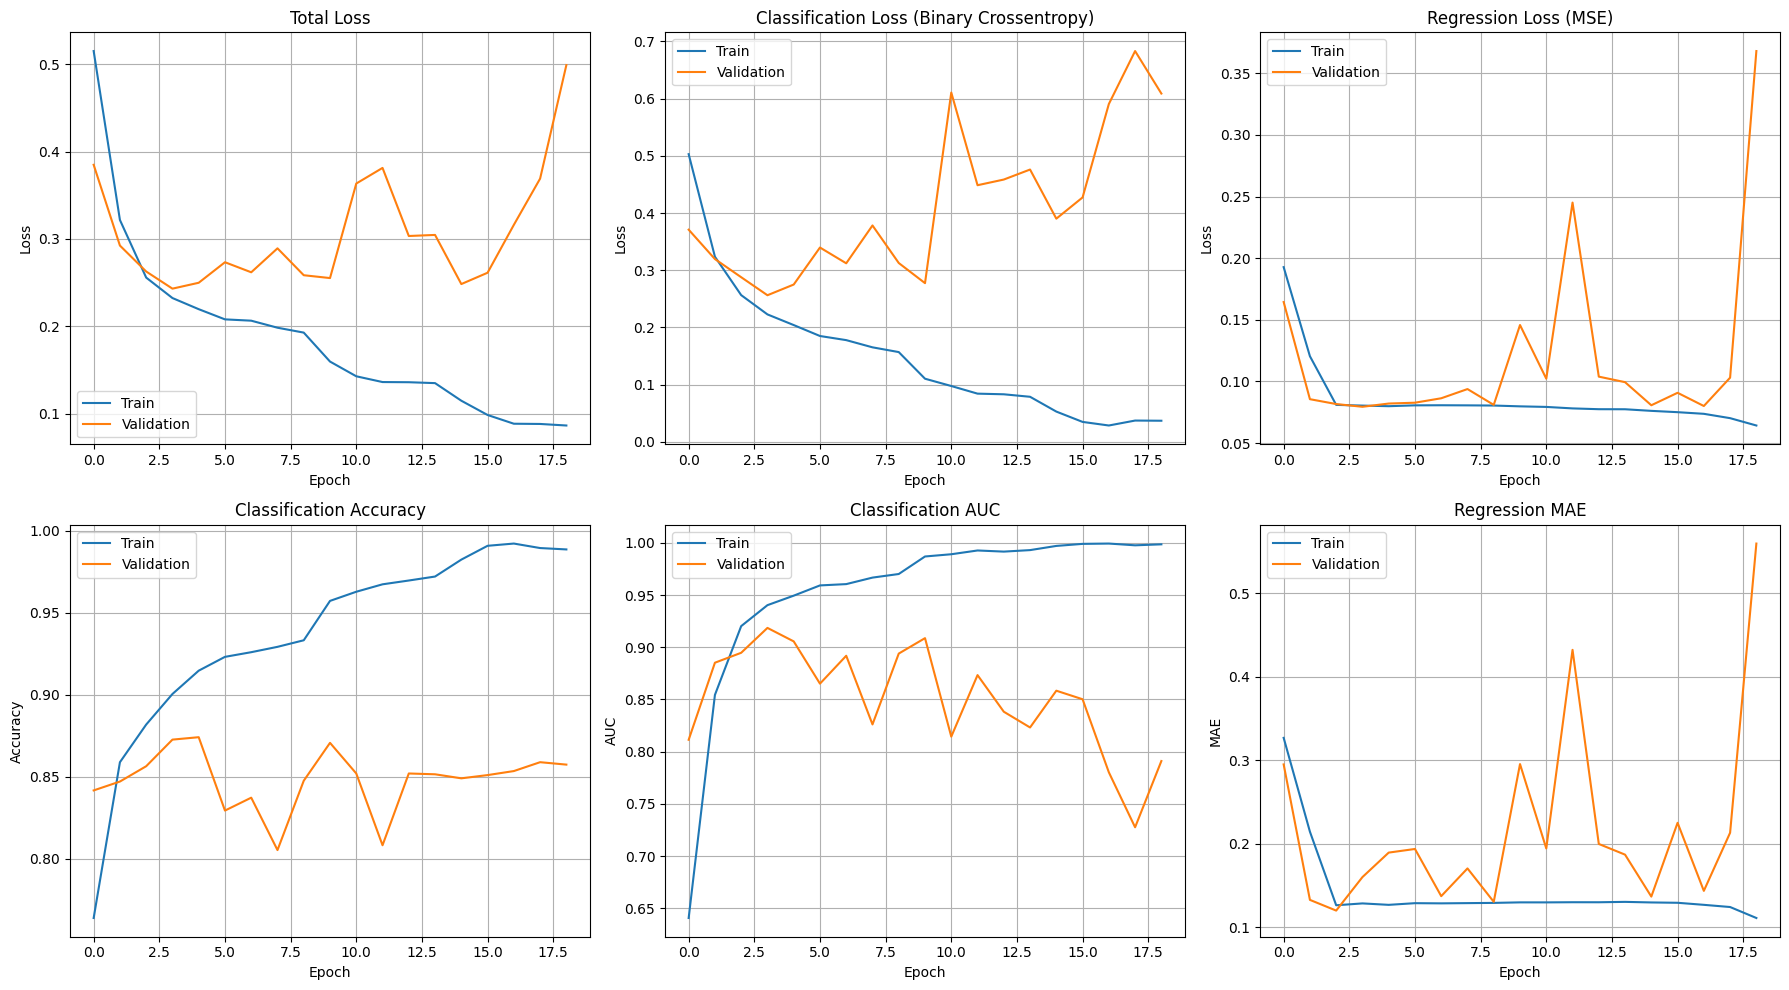

Training history plot saved to ..\MODELS\training_history.png


In [15]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Total loss
axes[0, 0].plot(history.history['loss'], label='Train')
axes[0, 0].plot(history.history['val_loss'], label='Validation')
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Classification loss
axes[0, 1].plot(history.history['classification_output_loss'], label='Train')
axes[0, 1].plot(history.history['val_classification_output_loss'], label='Validation')
axes[0, 1].set_title('Classification Loss (Binary Crossentropy)')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Regression loss
axes[0, 2].plot(history.history['regression_output_loss'], label='Train')
axes[0, 2].plot(history.history['val_regression_output_loss'], label='Validation')
axes[0, 2].set_title('Regression Loss (MSE)')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].legend()
axes[0, 2].grid(True)

# Classification accuracy
axes[1, 0].plot(history.history['classification_output_accuracy'], label='Train')
axes[1, 0].plot(history.history['val_classification_output_accuracy'], label='Validation')
axes[1, 0].set_title('Classification Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Classification AUC
axes[1, 1].plot(history.history['classification_output_auc'], label='Train')
axes[1, 1].plot(history.history['val_classification_output_auc'], label='Validation')
axes[1, 1].set_title('Classification AUC')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('AUC')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Regression MAE
axes[1, 2].plot(history.history['regression_output_mae'], label='Train')
axes[1, 2].plot(history.history['val_regression_output_mae'], label='Validation')
axes[1, 2].set_title('Regression MAE')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('MAE')
axes[1, 2].legend()
axes[1, 2].grid(True)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Training history plot saved to {MODEL_DIR / 'training_history.png'}")

## 10. Evaluate on Test Set

In [16]:
print("Evaluating on test set...\n")

# Get predictions
y_pred_class, y_pred_reg = model.predict(X_test, verbose=0)

# Flatten predictions
y_pred_class = y_pred_class.flatten()
y_pred_reg = y_pred_reg.flatten()

# ===== Classification Metrics =====
print("="*60)
print("CLASSIFICATION METRICS (Entry Confidence)")
print("="*60)

# Convert probabilities to binary predictions
y_pred_class_binary = (y_pred_class > 0.5).astype(int)

accuracy = accuracy_score(y_test_class, y_pred_class_binary)
precision = precision_score(y_test_class, y_pred_class_binary)
recall = recall_score(y_test_class, y_pred_class_binary)
f1 = f1_score(y_test_class, y_pred_class_binary)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_class, y_pred_class_binary)
print(cm)
print(f"\nClassification Report:")
print(classification_report(y_test_class, y_pred_class_binary, target_names=['Bad Bet', 'Good Bet']))

# ===== Regression Metrics =====
print("\n" + "="*60)
print("REGRESSION METRICS (Outcome Prediction)")
print("="*60)

mae = mean_absolute_error(y_test_reg, y_pred_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

# Direction accuracy (sign agreement)
sign_agreement = np.mean(np.sign(y_test_reg) == np.sign(y_pred_reg))
print(f"\nDirection Accuracy (Sign Agreement): {sign_agreement:.4f}")

Evaluating on test set...

CLASSIFICATION METRICS (Entry Confidence)
Accuracy:  0.8463
Precision: 0.5609
Recall:    0.4986
F1 Score:  0.5279

Confusion Matrix:
[[1548  137]
 [ 176  175]]

Classification Report:
              precision    recall  f1-score   support

     Bad Bet       0.90      0.92      0.91      1685
    Good Bet       0.56      0.50      0.53       351

    accuracy                           0.85      2036
   macro avg       0.73      0.71      0.72      2036
weighted avg       0.84      0.85      0.84      2036


REGRESSION METRICS (Outcome Prediction)
MAE:  0.1698
MSE:  0.0888
RMSE: 0.2979
R²:   -0.0041

Direction Accuracy (Sign Agreement): 0.2141


## 11. Visualize Predictions

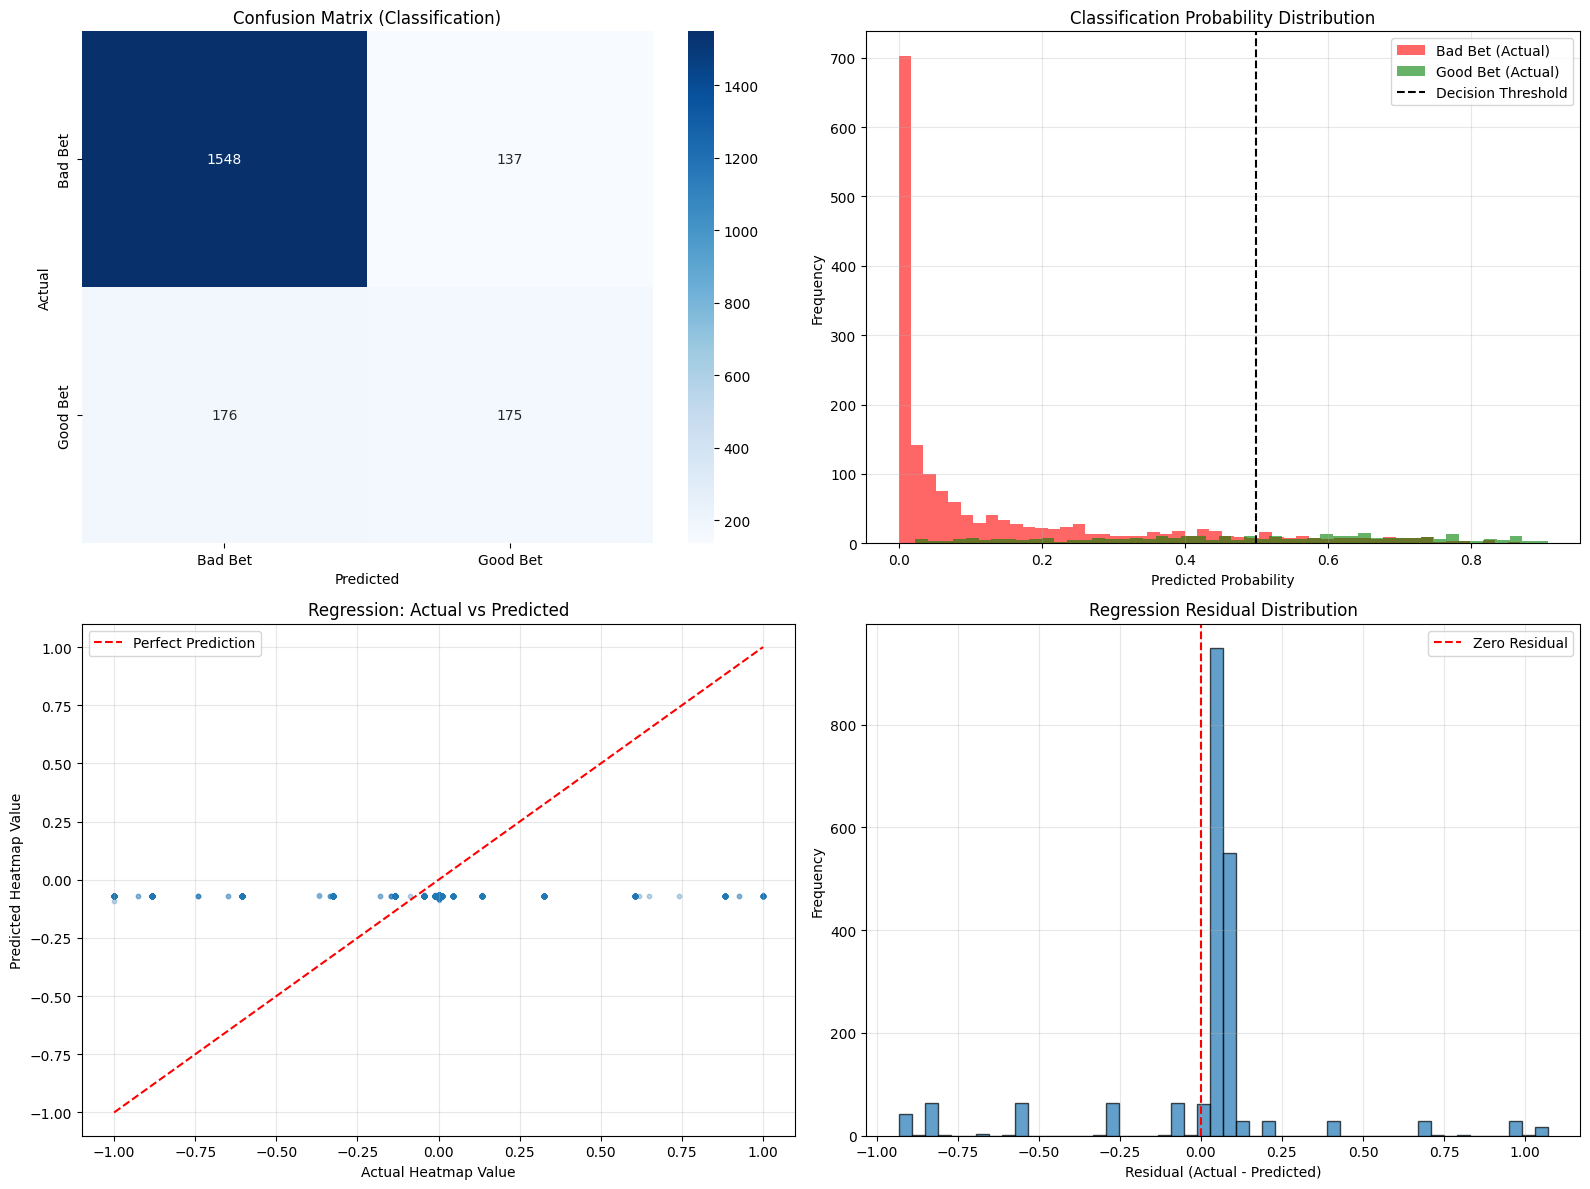

Predictions analysis plot saved to ..\MODELS\predictions_analysis.png


In [17]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Classification - Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix (Classification)')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xticklabels(['Bad Bet', 'Good Bet'])
axes[0, 0].set_yticklabels(['Bad Bet', 'Good Bet'])

# 2. Classification - Probability Distribution
axes[0, 1].hist(y_pred_class[y_test_class == 0], bins=50, alpha=0.6, label='Bad Bet (Actual)', color='red')
axes[0, 1].hist(y_pred_class[y_test_class == 1], bins=50, alpha=0.6, label='Good Bet (Actual)', color='green')
axes[0, 1].axvline(0.5, color='black', linestyle='--', label='Decision Threshold')
axes[0, 1].set_title('Classification Probability Distribution')
axes[0, 1].set_xlabel('Predicted Probability')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Regression - Scatter Plot
axes[1, 0].scatter(y_test_reg, y_pred_reg, alpha=0.3, s=10)
axes[1, 0].plot([-1, 1], [-1, 1], 'r--', label='Perfect Prediction')
axes[1, 0].set_title('Regression: Actual vs Predicted')
axes[1, 0].set_xlabel('Actual Heatmap Value')
axes[1, 0].set_ylabel('Predicted Heatmap Value')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim(-1.1, 1.1)
axes[1, 0].set_ylim(-1.1, 1.1)

# 4. Regression - Residual Distribution
residuals = y_test_reg - y_pred_reg
axes[1, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(0, color='red', linestyle='--', label='Zero Residual')
axes[1, 1].set_title('Regression Residual Distribution')
axes[1, 1].set_xlabel('Residual (Actual - Predicted)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'predictions_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Predictions analysis plot saved to {MODEL_DIR / 'predictions_analysis.png'}")

## 12. Meta-Labeling Strategy Analysis

Analyze how the dual outputs work together for meta-labeling:
- Only take trades where classification confidence is high
- Use regression output to size/manage the position

In [18]:
# Create meta-labeling strategy: only take trades with high classification confidence
confidence_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

print("Meta-Labeling Strategy Analysis")
print("=" * 80)
print(f"{'Conf Threshold':<15} {'Trades Taken':<15} {'Avg Heatmap':<15} {'Win Rate':<15} {'Directional Acc':<15}")
print("=" * 80)

for threshold in confidence_thresholds:
    # Select trades where classification confidence > threshold
    selected_mask = y_pred_class > threshold
    
    if selected_mask.sum() == 0:
        print(f"{threshold:<15.2f} {'No trades':<15} {'-':<15} {'-':<15} {'-':<15}")
        continue
    
    # Number of trades taken
    n_trades = selected_mask.sum()
    pct_trades = n_trades / len(y_test_reg) * 100
    
    # Average heatmap value (strength of signal)
    avg_heatmap = np.abs(y_test_reg[selected_mask]).mean()
    
    # Win rate (trades where heatmap is correct direction)
    win_rate = np.mean(np.abs(y_test_reg[selected_mask]) > CONFIDENCE_THRESHOLD)
    
    # Directional accuracy
    dir_acc = np.mean(np.sign(y_test_reg[selected_mask]) == np.sign(y_pred_reg[selected_mask]))
    
    print(f"{threshold:<15.2f} {f'{n_trades} ({pct_trades:.1f}%)':<15} {avg_heatmap:<15.4f} {win_rate:<15.2%} {dir_acc:<15.2%}")

print("=" * 80)

Meta-Labeling Strategy Analysis
Conf Threshold  Trades Taken    Avg Heatmap     Win Rate        Directional Acc
0.50            312 (15.3%)     0.4044          56.09%          55.45%         
0.60            214 (10.5%)     0.4522          61.21%          59.81%         
0.70            112 (5.5%)      0.4989          66.07%          65.18%         
0.80            36 (1.8%)       0.5991          80.56%          91.67%         
0.90            1 (0.0%)        0.3247          100.00%         100.00%        


## 13. Save Model and Results

In [19]:
# Save final model
model.save(MODEL_DIR / 'final_model.keras')
print(f"Model saved to {MODEL_DIR / 'final_model.keras'}")

# Save predictions
np.save(MODEL_DIR / 'y_test_class_true.npy', y_test_class)
np.save(MODEL_DIR / 'y_test_class_pred.npy', y_pred_class)
np.save(MODEL_DIR / 'y_test_reg_true.npy', y_test_reg)
np.save(MODEL_DIR / 'y_test_reg_pred.npy', y_pred_reg)
print("Predictions saved.")

# Save configuration and metrics
results = {
    'config': CONFIG,
    'test_metrics': {
        'classification': {
            'accuracy': float(accuracy),
            'precision': float(precision),
            'recall': float(recall),
            'f1_score': float(f1)
        },
        'regression': {
            'mae': float(mae),
            'mse': float(mse),
            'rmse': float(rmse),
            'r2': float(r2),
            'direction_accuracy': float(sign_agreement)
        }
    },
    'training_info': {
        'epochs_trained': len(history.history['loss']),
        'best_val_loss': float(min(history.history['val_loss'])),
        'final_train_loss': float(history.history['loss'][-1]),
        'final_val_loss': float(history.history['val_loss'][-1])
    }
}

with open(MODEL_DIR / 'results.json', 'w') as f:
    json.dump(results, f, indent=2)
print(f"Results saved to {MODEL_DIR / 'results.json'}")

print("\n" + "="*60)
print("Phase 3 Complete!")
print("="*60)
print("Next: Phase 4 - Custom Loss Functions (ConsistentPeakBFCE, Focal Loss)")

Model saved to ..\MODELS\final_model.keras
Predictions saved.
Results saved to ..\MODELS\results.json

Phase 3 Complete!
Next: Phase 4 - Custom Loss Functions (ConsistentPeakBFCE, Focal Loss)
